[*********************100%%**********************]  1 of 1 completed


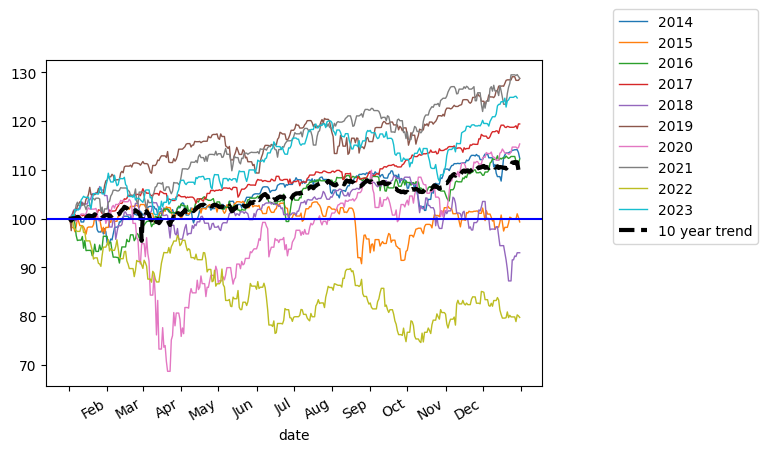

In [5]:
import pandas as pd
import yfinance as yf
import ssl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

# Read in the SP500 tickers
# ssl._create_default_https_context = ssl._create_unverified_context
# table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# df = table[0]
# df.to_csv('S&P500-Info.csv', index=False)
# df.to_csv("S&P500-Symbols.csv", columns=['Symbol'], index=False)


# Alternatively, read tickers from pre-existing csv
df = pd.read_csv("S&P500-Symbols.csv")
tickers = df['Symbol']


# Fetch data
#data = yf.download(tickers,'2015-1-1')['Adj Close']

# Import SP500 index
start_date = '2014-01-01'
end_date = '2024-01-05' # go a bit into 2024 to forward-fill
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date,end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates,method='bfill')
spx = spx[spx.Date<'2024-01-01']

# Assign year, and attach
spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')

spx['Yr Init Price'] = spx.groupby('Year',sort=False).transform('first'
    )['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close']/spx['Yr Init Price']*100

# Now take averages over the last 10 years
spx10yr = spx.groupby('Month Day').mean()
spx10yr['plot date'] = list(spx10yr.reset_index()['Month Day'].apply(lambda x: 
                        datetime.strptime("2000-"+x, "%Y-%m-%d")))

# Plot
fig, ax = plt.subplots()

for label, dfy in spx.assign(
    # Set to 2000 because it has Feb 29
    date=pd.to_datetime(spx.index.strftime('2000-%m-%d')),
    year=spx.index.strftime('%Y')
).groupby('year'):
    dfy.set_index('date')['Seasonal Trend Price'].plot(ax=ax, label=str(label),linewidth=1)

ax.plot(spx10yr['plot date'], spx10yr['Seasonal Trend Price'],
    label='10 year trend',linewidth=3.0,linestyle='dashed',color='black')
ax.axhline(y=100,color='blue')

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(bbox_to_anchor=(1, 1),
          bbox_transform=fig.transFigure)


In [24]:
spx10yr.loc['04-01']

Adj Close                       2898.663965
Price Date              2018-10-01 04:48:00
Year                                 2018.5
Yr Init Price                   2894.571008
Seasonal Trend Price             100.754507
plot date               2000-04-01 00:00:00
Name: 04-01, dtype: object

In [33]:
import numpy as np
start_date = '2004-01-01'
end_date = '2023-01-05'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date,end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates,method='bfill')
spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')
spx['Yr Init Price'] = spx.groupby('Year',sort=False).transform('first'
    )['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close']/spx['Yr Init Price']*100
spx['Yr Group'] = np.select(
    condlist=[spx.Year<2009, spx.Year<2014, spx.Year<2019],
    choicelist=['2004-2008 Trend','2009-2013 Trend','2014-2018 Trend'],
    default = ['2019-2023 Trend'])


[*********************100%%**********************]  1 of 1 completed


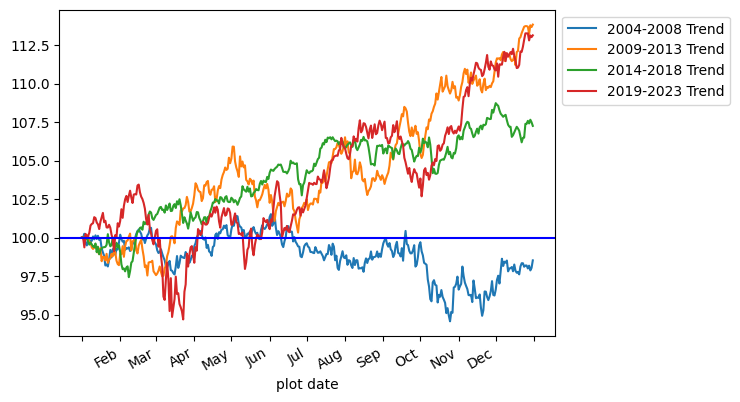

In [39]:
fig, ax = plt.subplots()

spx5yr = spx.groupby(['Month Day','Yr Group']).mean()
spx5yr['plot date'] = list(spx5yr.reset_index()['Month Day'].apply(lambda x: 
                        datetime.strptime("2000-"+x, "%Y-%m-%d")))
spx5yr=spx5yr[spx5yr['plot date']!='2000-02-29']

for label, dfy in spx5yr.groupby('Yr Group'):
    dfy.set_index('plot date')['Seasonal Trend Price'].plot(ax=ax, label=str(label))


locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(1, 1),loc='upper left')

ax.axhline(y=100,color='blue')


In [60]:
spx10yr.reset_index()['Month Day'].apply(lambda x: 
                        datetime.strptime("2000-"+x, "%Y-%m-%d"))

0     2000-01-01
1     2000-01-02
2     2000-01-03
3     2000-01-04
4     2000-01-05
         ...    
361   2000-12-27
362   2000-12-28
363   2000-12-29
364   2000-12-30
365   2000-12-31
Name: Month Day, Length: 366, dtype: datetime64[ns]

In [115]:
spx10yr.loc['02-19']

Adj Close                       3674.943945
Price Date              2021-02-19 14:24:00
Year                                 2021.0
Yr Init Price                   3617.845996
Seasonal Trend Price             102.905683
plot date               2000-02-19 00:00:00
Name: 02-19, dtype: object

In [118]:
spx[spx['Month Day']=='03-05']

,Adj Close,Price Date,Year,Month Day,Yr Init Price,Seasonal Trend Price
2019-03-05,2789.649902,2019-03-05,2019,03-05,2510.030029,111.140101
2020-03-05,3023.939941,2020-03-05,2020,03-05,3257.850098,92.820107
2021-03-05,3841.939941,2021-03-05,2021,03-05,3700.649902,103.817979
2022-03-05,4201.089844,2022-03-07,2022,03-05,4796.560059,87.585474
2023-03-05,4048.419922,2023-03-06,2023,03-05,3824.139893,105.864849


In [70]:
spx['Price Date'] = spx.index

In [119]:
spx10yr.loc['03-05']


Adj Close                        3581.00791
Price Date              2021-03-05 09:36:00
Year                                 2021.0
Yr Init Price                   3617.845996
Seasonal Trend Price             100.245702
plot date               2000-03-05 00:00:00
Name: 03-05, dtype: object

In [74]:
spx['Year'] = spx.index.year

In [75]:
spx

,Adj Close,Price Date,Year
Date,,,
2000-01-03,1455.219971,2000-01-03,2000
2000-01-04,1399.420044,2000-01-04,2000
2000-01-05,1402.109985,2000-01-05,2000
2000-01-06,1403.449951,2000-01-06,2000
2000-01-07,1441.469971,2000-01-07,2000
...,...,...,...
2024-01-08,4763.540039,2024-01-08,2024
2024-01-09,4756.500000,2024-01-09,2024
2024-01-10,4783.450195,2024-01-10,2024


In [2]:
import pandas as pd
import numpy as np
# setup
idx = pd.date_range('2016-01-01', 'now', freq='QS')
df = pd.DataFrame(
    {'var': np.random.uniform(size=len(idx))},
    index=idx).resample('D').interpolate(method='polynomial', order=5)

AttributeError: 'RangeIndex' object has no attribute 'strftime'

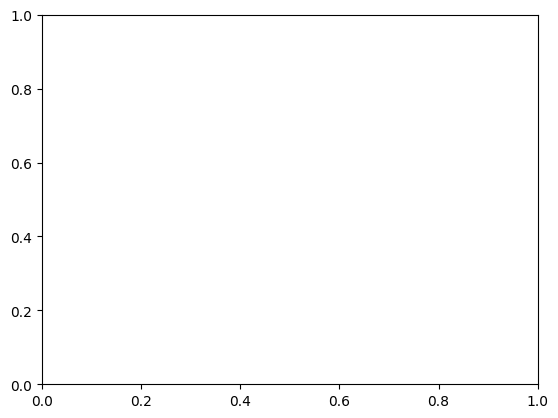

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
for label, dfy in df.assign(
    # note: 2000 is a leap year; the choice is deliberate
    date=pd.to_datetime(df.index.strftime('2000-%m-%d')),
    label=df.index.strftime('%Y')
).groupby('label'):
    dfy.set_index('date')['var'].plot(ax=ax, label=str(label))
ax.legend()

locator = mdates.AutoDateLocator(minticks=3, maxticks=12)
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

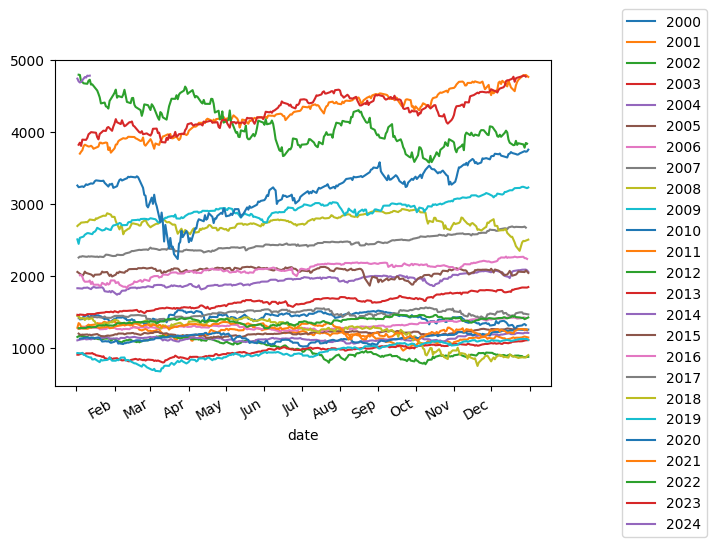

In [23]:
fig, ax = plt.subplots()
for label, dfy in spx.assign(
    # Set to 2000 because it has Feb 29
    date=pd.to_datetime(spx.index.strftime('2000-%m-%d')),
    year=spx.index.strftime('%Y')
).groupby('year'):
    dfy.set_index('date')['Adj Close'].plot(ax=ax, label=str(label))
ax.legend()

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(1, 1),
          bbox_transform=fig.transFigure)

In [10]:
2+2

4